In [1]:
from ceviche import fdtd
from ceviche.constants import *
from ceviche.utils import aniplot, measure_fields, get_spectrum, get_max_power_freq, get_spectral_power, plot_spectral_power
import autograd.numpy as np
import matplotlib.pylab as plt
plt.style.use('dark_background')

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Load in the permittivity distribution from an FDFD simulation

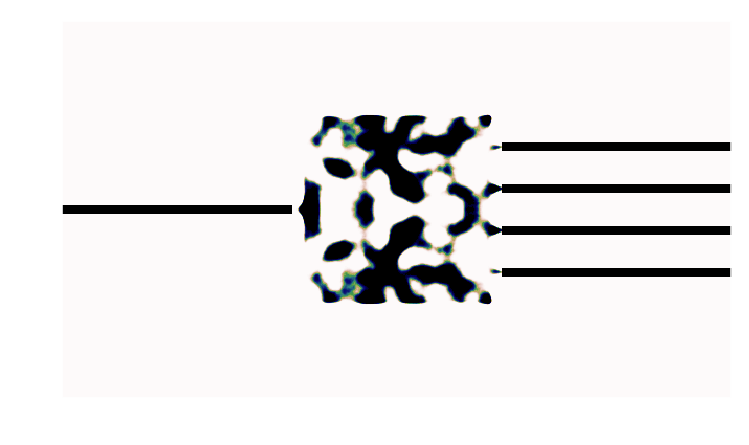

In [2]:
def reshape_arr(arr, Nx, Ny):
    return arr.reshape((Nx, Ny, 1))

eps_r = np.load('data/eps_r_splitter4.npy')
eps_wg = np.load('data/eps_waveguide.npy')
plt.imshow(eps_r.T, cmap='gist_earth_r')
plt.show()

Nx, Ny = eps_r.shape

J_in = np.load('data/J_in.npy')
J_outs = np.load('data/J_list.npy')
J_wg = np.flipud(J_in.copy())

eps_wg = reshape_arr(eps_wg, Nx, Ny)
eps_r = reshape_arr(eps_r, Nx, Ny)
J_in = reshape_arr(J_in, Nx, Ny)
J_outs = [reshape_arr(J, Nx, Ny) for J in J_outs]
J_wg = reshape_arr(J_wg, Nx, Ny)

Nz = 1

Initial setting up of parameters

In [46]:
nx, ny, nz = Nx//2, Ny//2, Nz//2

dL = 5e-8
pml = [20, 20, 0]

F = fdtd(eps_r, dL=dL, npml=pml)
F_wg = fdtd(eps_wg, dL=dL, npml=pml)

# source parameters
steps = 10000
t0 = 2000
sigma = 100      
source_amp = 5
omega = 2 * np.pi * C_0 / 2e-6  # units of 1/sec
omega_sim = omega * F.dt       # unitless time

gaussian = lambda t: np.exp(-(t - t0)**2 / 2 / sigma**2) * np.cos(omega_sim * t)
source = lambda t: J_in * source_amp * gaussian(t)

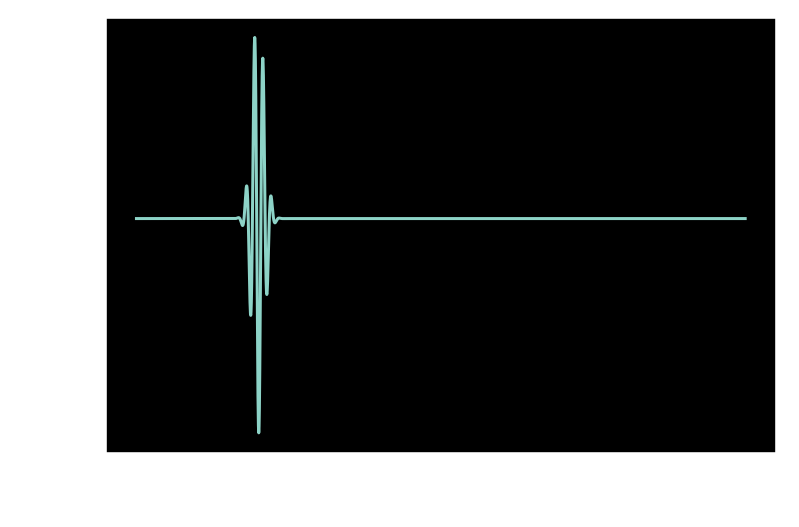

In [47]:
plt.plot(1e15 * F.dt * np.arange(steps), gaussian(np.arange(steps)))
plt.xlabel('time (femtoseconds)')
plt.ylabel('source amplitude')
plt.show()

Compute the transmission (as a function of time) for a straight waveguide (to normalize later)

In [48]:
measured_wg = measure_fields(F_wg, source, steps, J_wg)

0.00 % done
5.00 % done
10.00 % done
15.00 % done
20.00 % done
25.00 % done
30.00 % done
35.00 % done
40.00 % done
45.00 % done
50.00 % done
55.00 % done
60.00 % done
65.00 % done
70.00 % done
75.00 % done
80.00 % done
85.00 % done
90.00 % done
95.00 % done


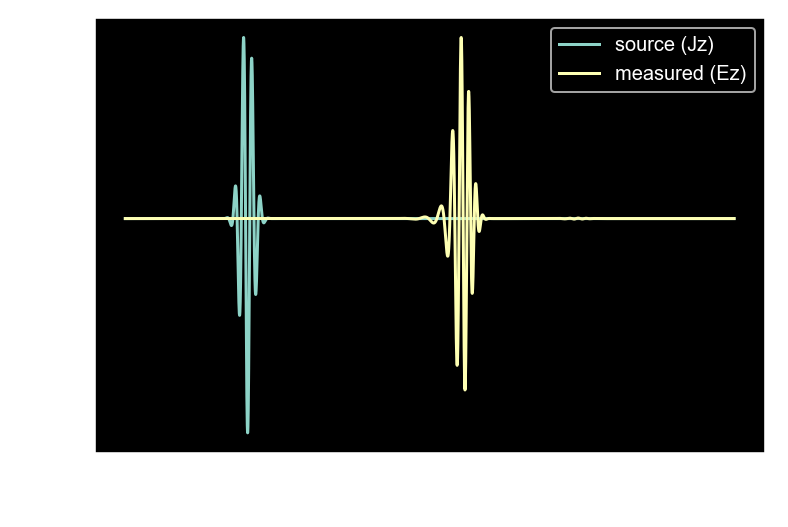

In [49]:
plt.plot(1e15 * F.dt*np.arange(steps), gaussian(np.arange(steps))/gaussian(np.arange(steps)).max(), label='source (Jz)')
plt.plot(1e15 * F.dt*np.arange(steps), measured_wg/measured_wg.max(), label='measured (Ez)')
plt.xlabel('time (femtoseconds)')
plt.ylabel('amplitude')
plt.legend()
plt.show()

Show the field plots at 10 time steps

In [20]:
aniplot(F_wg, source, steps, num_panels=10)

working on axis 0/10 for time step 0
working on axis 1/10 for time step 500
working on axis 2/10 for time step 1000
working on axis 3/10 for time step 1500
working on axis 4/10 for time step 2000
working on axis 5/10 for time step 2500
working on axis 6/10 for time step 3000
working on axis 7/10 for time step 3500
working on axis 8/10 for time step 4000
working on axis 9/10 for time step 4500


Compute the power spectrum transmitted

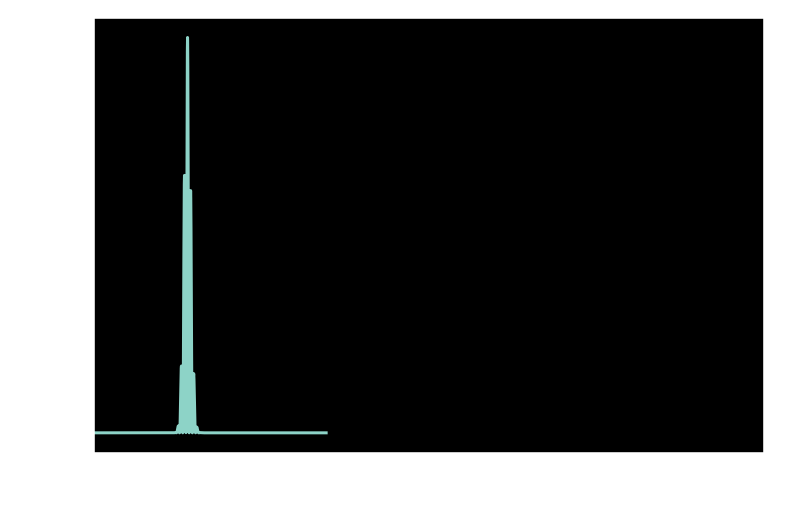

In [50]:
plot_spectral_power(gaussian(np.arange(steps)), F.dt, f_top=3e16)

In [28]:
gaussian(np.arange(steps)).shape


(5000,)

Now for the measured fields

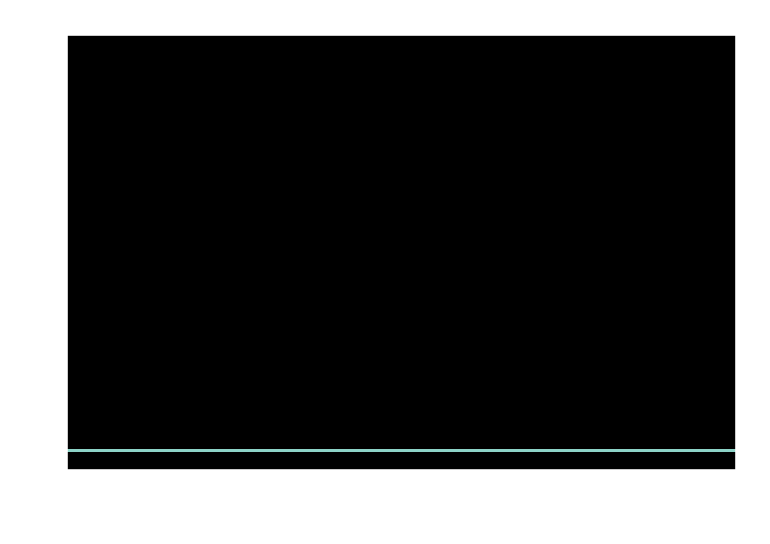

In [41]:
plot_spectral_power(measured_wg[:,0], F.dt, f_top=2e14)

Now measure the transmission for the inverse designed splitter (at each of the four ports)

In [ ]:
measured = measure_fields(F, source, steps, J_outs)

In [ ]:
ham = np.hamming(steps).reshape((steps,1))
# plt.plot(measured*ham**5)
plot_spectral_power(measured*ham**100, dt=F.dt, f_top=4e16)

In [ ]:
plt.plot(1e15 * F.dt*np.arange(steps), gaussian(np.arange(steps))/gaussian(np.arange(steps)).max(), label='source (Jz)')
plt.plot(1e15 * F.dt*np.arange(steps), measured/measured.max(), label='measured (Ez)')
plt.xlabel('time (femtoseconds)')
plt.ylabel('amplitude')
plt.legend()
plt.show()

In [ ]:
aniplot(F_wg, source, steps, num_panels=10)

In [ ]:
series_in = gaussian(np.arange(steps))
series_wg = None
plot_spectral_power(measured_wg, F.dt, f_top=15e14)

In [ ]:
series_in = gaussian(np.arange(steps))

In [ ]:
measured_wg

In [ ]:
freq1, spect1 = get_spectrum(series_in, dt=F.dt)
freq2, spect2 = get_spectrum(measured_wg, dt=F.dt)

plt.plot(series_in/series_in.max())
plt.plot(measured_wg/measured_wg.max())
plt.show()

spect1 = np.fft.fft(series_in/series_in.max())
spect2 = np.fft.fft(measured_wg/measured_wg.max())
plt.plot(np.fft.fftshift(np.abs(spect1)))
plt.plot(np.fft.fftshift(np.abs(spect2)))
plt.show()

plt.plot(freq1, np.abs(spect1/spect1.max()))
plt.plot(freq2, np.abs(spect2/spect2.max()))
plt.show()

In [ ]:
freq, spect = get_spectrum(measured_wg, dt=F.dt)
plt.plot(freq, np.abs(spect))
plt.xlim([0, 4e14])
ex = 1e-50
plt.ylim([-0.1*ex, ex])
plt.show()

In [ ]:
plot_spectral_power(measured, dt=F.dt, f_top=1e16)

In [ ]:
plt.plot(series_in)
series_out = measured_wg/measured_wg.max()
plt.plot(series_out)

In [ ]:
plt.plot(np.abs(np.fft.fft(series_in*np.hanning(steps))))
plt.plot(np.abs(np.fft.fft(series_out*np.hanning(steps))))

In [ ]:
(measured_wg*np.hamming(steps)).shape

In [ ]:
plt.plot(np.hamming(steps))

In [ ]:
F.dt

In [ ]:
from ceviche.utils import get_spectrum_lr
get_spectrum_lr(measured_wg[:,0], dt=F.dt)


In [ ]:
get_spectrum_lr(gaussian(np.arange(steps)), dt=F.dt)